<a href="https://colab.research.google.com/github/mkierczak/autoencoders_workshop/blob/main/PCA2VAE_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.regularizers import l1
from matplotlib import pyplot as plt
from keras.utils import plot_model
from keras import backend
from sklearn.decomposition import PCA
from itertools import product

If you want to try another dataset, you can go for data from Lazaridis et. al. [*Genomic insights into the origin of farming in the ancient Near East*](https://www.nature.com/articles/nature19310) 2016. Nature **536**:419-424. I have pre-prepared chr1 markers at call rate of 0.99 and higher.

In [ ]:
# HapMap3 randomly selected 5000 autosomal markers data
!wget -O data.hd5 https://www.dropbox.com/scl/fi/2daedhwkdjweotnthxee3/HapMap3_5000.h5?rlkey=nz8f9df7tt9n0hrpqg7y19omc&dl=1

# Data for chr1 from Lazaridis et al.
#!wget -O data.hd5 https://www.dropbox.com/scl/fi/kck4puyi1qmuzr65bgdbn/HumanOriginsPublic2068_geno_chr1.h5?rlkey=xp4nfljz0c2za9ihriletxx3x&dl=1


--2023-09-05 06:44:34--  https://www.dropbox.com/scl/fi/2daedhwkdjweotnthxee3/HapMap3_5000.h5?rlkey=nz8f9df7tt9n0hrpqg7y19omc
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/2daedhwkdjweotnthxee3/HapMap3_5000.h5?rlkey=nz8f9df7tt9n0hrpqg7y19omc [following]
--2023-09-05 06:44:35--  https://www.dropbox.com/e/scl/fi/2daedhwkdjweotnthxee3/HapMap3_5000.h5?rlkey=nz8f9df7tt9n0hrpqg7y19omc
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbdbbe6f7a8f7f312c1a338a109.dl.dropboxusercontent.com/cd/0/inline/CDJdchDQIAw1aps46nqVZTQkemc_qW-l1x_-15fHF2vp9nlXEqQSlpwKuBVI20lP0A97JRpsDPWeJJA6hYlXu0dlOp1D0Ifznyo9Nl5gdnXGv6cV2jQqQuTvclqM1P9_fgA/file# [following]
--2023-09-05 06:44:36--  https://ucbdbbe6f7a8f7f312c1a338a109.dl

In [ ]:
orig_geno = pd.read_hdf('./data.hd5', key = 'geno')
orig_pheno = pd.read_hdf('./data.hd5', key = 'pheno')
orig_gkin = pd.read_hdf('./data.hd5', key = 'gkin')


In [ ]:
orig_geno.info()
orig_geno.iloc[0:4, 0:4]

<class 'pandas.core.frame.DataFrame'>
Index: 1184 entries, NA19919 to NA19099
Columns: 5000 entries, rs416967 to rs2806497
dtypes: int64(5000)
memory usage: 45.2+ MB


,NA19919,NA19916,NA19835,NA20282,NA19703,NA19902,NA19901,NA19908,NA19914,NA20287,...,NA18853,NA19173,NA19171,NA19140,NA18859,NA19119,NA18860,NA19207,NA19103,NA19099
NA19919,1.000000,0.956045,0.991299,0.998115,0.966539,0.984490,0.969456,0.720372,0.993620,0.987785,...,0.973502,0.976022,0.974834,0.977329,0.977305,0.969765,0.964101,0.984822,0.978650,0.978933
NA19916,0.956045,1.000000,0.987325,0.997055,0.972959,0.988437,0.983771,0.950670,0.987508,0.965180,...,0.979353,0.966666,0.965574,0.972000,0.987989,0.965478,0.984434,0.950259,0.958601,0.971893
NA19835,0.991299,0.987325,1.000000,0.973136,0.974283,0.981403,0.982401,0.978460,0.990013,1.003244,...,0.971275,0.984477,0.967848,0.983973,0.969998,0.979433,0.974723,0.980122,0.988978,0.974627
NA20282,0.998115,0.997055,0.973136,1.000000,0.997064,1.002880,0.989643,0.987173,1.004836,0.977272,...,0.983496,0.988047,0.976974,0.980222,0.975953,0.973370,0.977145,0.984446,0.991740,0.992266


In [ ]:
orig_pheno.iloc[0:4, ]

,id,sex,FID,dad,mom,pheno,population
NA19919,NA19919,1,2427,NA19908,NA19909,0,African ancestry in SW USA
NA19916,NA19916,1,2431,0,0,0,African ancestry in SW USA
NA19835,NA19835,0,2424,0,0,0,African ancestry in SW USA
NA20282,NA20282,0,2469,0,0,0,African ancestry in SW USA


In [ ]:
orig_gkin.iloc[0:4, ]

,NA19919,NA19916,NA19835,NA20282,NA19703,NA19902,NA19901,NA19908,NA19914,NA20287,...,NA18853,NA19173,NA19171,NA19140,NA18859,NA19119,NA18860,NA19207,NA19103,NA19099
NA19919,1.000000,0.956045,0.991299,0.998115,0.966539,0.984490,0.969456,0.720372,0.993620,0.987785,...,0.973502,0.976022,0.974834,0.977329,0.977305,0.969765,0.964101,0.984822,0.978650,0.978933
NA19916,0.956045,1.000000,0.987325,0.997055,0.972959,0.988437,0.983771,0.950670,0.987508,0.965180,...,0.979353,0.966666,0.965574,0.972000,0.987989,0.965478,0.984434,0.950259,0.958601,0.971893
NA19835,0.991299,0.987325,1.000000,0.973136,0.974283,0.981403,0.982401,0.978460,0.990013,1.003244,...,0.971275,0.984477,0.967848,0.983973,0.969998,0.979433,0.974723,0.980122,0.988978,0.974627
NA20282,0.998115,0.997055,0.973136,1.000000,0.997064,1.002880,0.989643,0.987173,1.004836,0.977272,...,0.983496,0.988047,0.976974,0.980222,0.975953,0.973370,0.977145,0.984446,0.991740,0.992266


In [ ]:
print("Missing genotypes per marker: \n", orig_geno.isna().sum())

Missing genotypes per marker: 
 rs416967      0
rs17013842    0
rs13052452    0
rs11049986    0
rs10994341    0
             ..
rs6557516     0
rs7313246     0
rs317892      0
rs11937009    0
rs2806497     0
Length: 5000, dtype: int64


In [ ]:
geno = orig_geno.replace([0, 1.0, 2.0], [0, 0.5, 1.0])
#geno.fillna(0, inplace = True)
#print(geno.isna().sum())
geno


,rs416967,rs17013842,rs13052452,rs11049986,rs10994341,rs1504289,rs882529,rs3885937,rs537330,rs9372090,...,rs1558766,rs7818288,rs1051685,rs11223492,rs789492,rs6557516,rs7313246,rs317892,rs11937009,rs2806497
NA19919,1.0,0.5,0.0,0.5,0.5,0.0,0.0,0.5,0.5,0.5,...,0.0,0.5,0.0,0.0,0.5,0.0,0.5,0.5,0.5,0.0
NA19916,0.5,0.0,0.0,0.5,0.5,0.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.0
NA19835,0.0,0.0,0.5,0.5,0.0,0.5,0.0,1.0,1.0,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
NA20282,0.5,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.0
NA19703,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,1.0,...,0.0,0.5,0.5,0.0,0.5,0.5,0.5,0.5,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA19119,0.5,0.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
NA18860,0.5,0.0,0.0,0.5,0.5,0.0,0.0,0.5,1.0,0.5,...,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5
NA19207,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,0.0
NA19103,0.5,0.0,0.5,0.0,0.0,0.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,1.0,0.0


In [ ]:
train = geno.sample(frac = 0.8, random_state = 42)
test = geno.drop(train.index)
pheno = orig_pheno.set_index(keys = 'id')
train_pheno = pheno[pheno.index.isin(train.index)]
test_pheno = pheno.drop(train.index)
train.reset_index()
test.reset_index()
train_pheno.reset_index()
test_pheno.reset_index()

# Print some info about the resulting split
print("Original data:", orig_geno.shape)
print("\t - training set:", train.shape)
print("\t - test set:", test.shape)

Original data: (1184, 5000)
	 - training set: (947, 5000)
	 - test set: (237, 5000)


In [ ]:
pheno

,sex,FID,dad,mom,pheno,population
id,,,,,,
NA19919,1,2427,NA19908,NA19909,0,African ancestry in SW USA
NA19916,1,2431,0,0,0,African ancestry in SW USA
NA19835,0,2424,0,0,0,African ancestry in SW USA
NA20282,0,2469,0,0,0,African ancestry in SW USA
NA19703,1,2368,0,0,0,African ancestry in SW USA
...,...,...,...,...,...,...
NA19119,1,Y060,0,0,0,Yoruba in Ibadan Nigeria
NA18860,1,Y012,NA18859,NA18858,0,Yoruba in Ibadan Nigeria
NA19207,1,Y051,0,0,0,Yoruba in Ibadan Nigeria


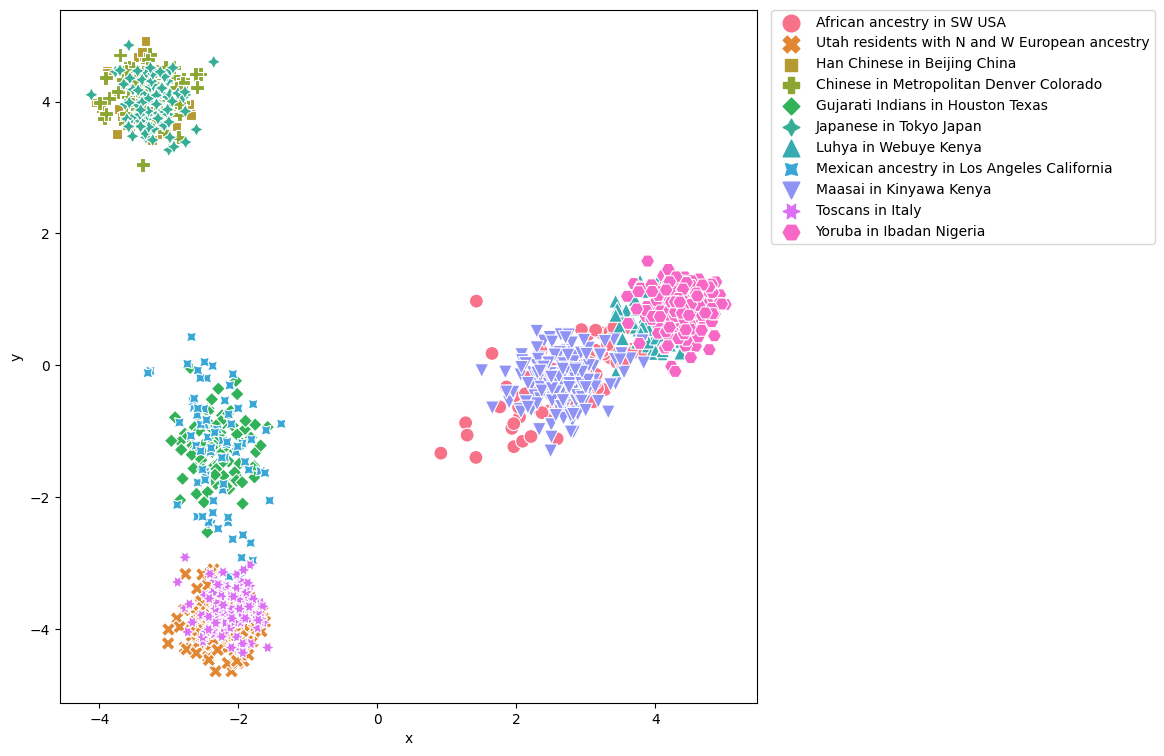

In [ ]:
embedding = PCA(n_components=2)
pca_embedding = embedding.fit_transform(geno)
x = pca_embedding[:,0]
y = pca_embedding[:,1]
pop = pheno.iloc[:,5]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (9,9))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100, legend=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

In [ ]:
#geno_imputed = orig_gt.fillna(orig_gt.mode().iloc[0])
#embedding = PCA(n_components=2)
#pca_embedding = embedding.fit_transform(geno_imputed) * 2
#x = pca_embedding[:,0]
#y = pca_embedding[:,1]
#pop = pheno.iloc[:,1]
#data = {'x':x, 'y':y, 'pop':pop}
#plt.figure(figsize = (9,9))
#sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100, legend=False)
#plt.show()

In [ ]:
train_tensor = train.to_numpy()
test_tensor = test.to_numpy()
original_dim = train_tensor.shape[1]
latent_dim = 2
print(type(train_tensor))

<class 'numpy.ndarray'>


In [ ]:
input = keras.Input(shape = (original_dim,))
output = input

def Encoder(input, latent_dim):
  h = layers.Dense(units = 1500, activation = 'relu')(input)
  h = layers.BatchNormalization()(h)
  h = layers.Dropout(rate = 0.05)(h)
  h = layers.Dense(units = 250, activation = 'relu')(h)
  h = layers.Dense(units = 25, activation = 'relu')(h)
  h = layers.Dense(units = latent_dim, name = 'bottleneck')(h)
  return(h)

def Decoder(bottleneck, original_dim):
  h = layers.Dense(units = 25, activation = 'relu')(bottleneck)
  h = layers.Dense(units = 250, activation = 'relu')(h)
  h = layers.Dense(units = 1500, activation = 'relu')(h)
  h = layers.Dense(original_dim, activation='sigmoid')(h)
  return(h)

def Autoencoder(input, latent_dim, original_dim):
  encoder = Encoder(input, latent_dim)
  autoencoder = Decoder(encoder, original_dim)
  return(autoencoder)

ae_model = keras.Model(inputs = input, outputs = Autoencoder(input, latent_dim, original_dim))

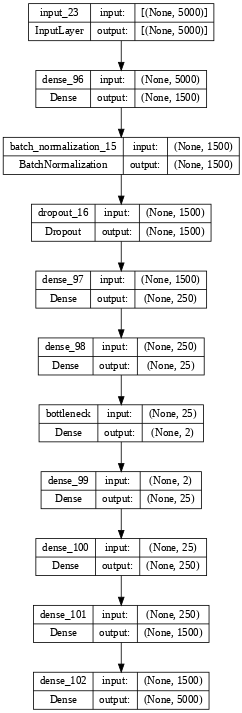

In [ ]:
plot_model(ae_model, show_shapes=True, show_layer_names = True, dpi=58, to_file="model.png")

In [ ]:
hp_loss_fn = keras.losses.MeanSquaredError()
hp_optimizer = 'adam'
hp_metrics = ['mse','mae']

ae_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics
)
ae_model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 5000)]            0         
                                                                 
 dense_96 (Dense)            (None, 1500)              7501500   
                                                                 
 batch_normalization_15 (Bat  (None, 1500)             6000      
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 1500)              0         
                                                                 
 dense_97 (Dense)            (None, 250)               375250    
                                                                 
 dense_98 (Dense)            (None, 25)                6275      
                                                          

In [ ]:
hp_epochs = 30
hp_batch_size = 32
hp_val_split = 0.2

autoencoder = ae_model.fit(x = train_tensor,
                      y = train_tensor,
                      epochs = hp_epochs,
                      batch_size = hp_batch_size,
                      shuffle = True,
                      validation_split = hp_val_split,
                      )

Epoch 1/30
24/24 [==============================] - 7s 279ms/step - loss: 0.0647 - mse: 0.0647 - mae: 0.1864 - val_loss: 0.0672 - val_mse: 0.0672 - val_mae: 0.2030
Epoch 2/30
24/24 [==============================] - 5s 197ms/step - loss: 0.0652 - mse: 0.0652 - mae: 0.1865 - val_loss: 0.0669 - val_mse: 0.0669 - val_mae: 0.2013
Epoch 3/30
24/24 [==============================] - 6s 234ms/step - loss: 0.0651 - mse: 0.0651 - mae: 0.1866 - val_loss: 0.0650 - val_mse: 0.0650 - val_mae: 0.1917
Epoch 4/30
24/24 [==============================] - 5s 191ms/step - loss: 0.0650 - mse: 0.0650 - mae: 0.1855 - val_loss: 0.0654 - val_mse: 0.0654 - val_mae: 0.1920
Epoch 5/30
24/24 [==============================] - 5s 208ms/step - loss: 0.0649 - mse: 0.0649 - mae: 0.1856 - val_loss: 0.0649 - val_mse: 0.0649 - val_mae: 0.1823
Epoch 6/30
24/24 [==============================] - 5s 216ms/step - loss: 0.0644 - mse: 0.0644 - mae: 0.1850 - val_loss: 0.0648 - val_mse: 0.0648 - val_mae: 0.1902
Epoch 7/30
24/24

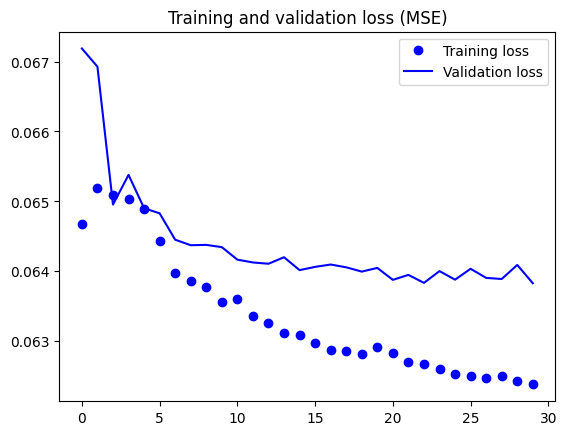

In [ ]:
loss = autoencoder.history['loss']
val_loss = autoencoder.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (MSE)')
plt.legend()
plt.show()

In [ ]:
geno_tensor = geno.to_numpy()
geno_dim = geno_tensor.shape[1]
input = keras.Input(shape = (geno_dim,))

trained_encoder = keras.Model(ae_model.input, ae_model.get_layer("bottleneck").output)
trained_encoder.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 5000)]            0         
                                                                 
 dense_96 (Dense)            (None, 1500)              7501500   
                                                                 
 batch_normalization_15 (Bat  (None, 1500)             6000      
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 1500)              0         
                                                                 
 dense_97 (Dense)            (None, 250)               375250    
                                                                 
 dense_98 (Dense)            (None, 25)                6275      
                                                          

37/37 [==============================] - 1s 17ms/step
[[-1.6797625e+01  1.8998082e+00]
 [-1.4276659e+01 -7.2110599e-01]
 [-1.6883005e+01  3.1117983e-03]
 ...
 [-1.6788702e+01 -1.9193560e+00]
 [-1.6246155e+01 -9.1496152e-01]
 [-1.6254444e+01 -2.3561735e+00]]


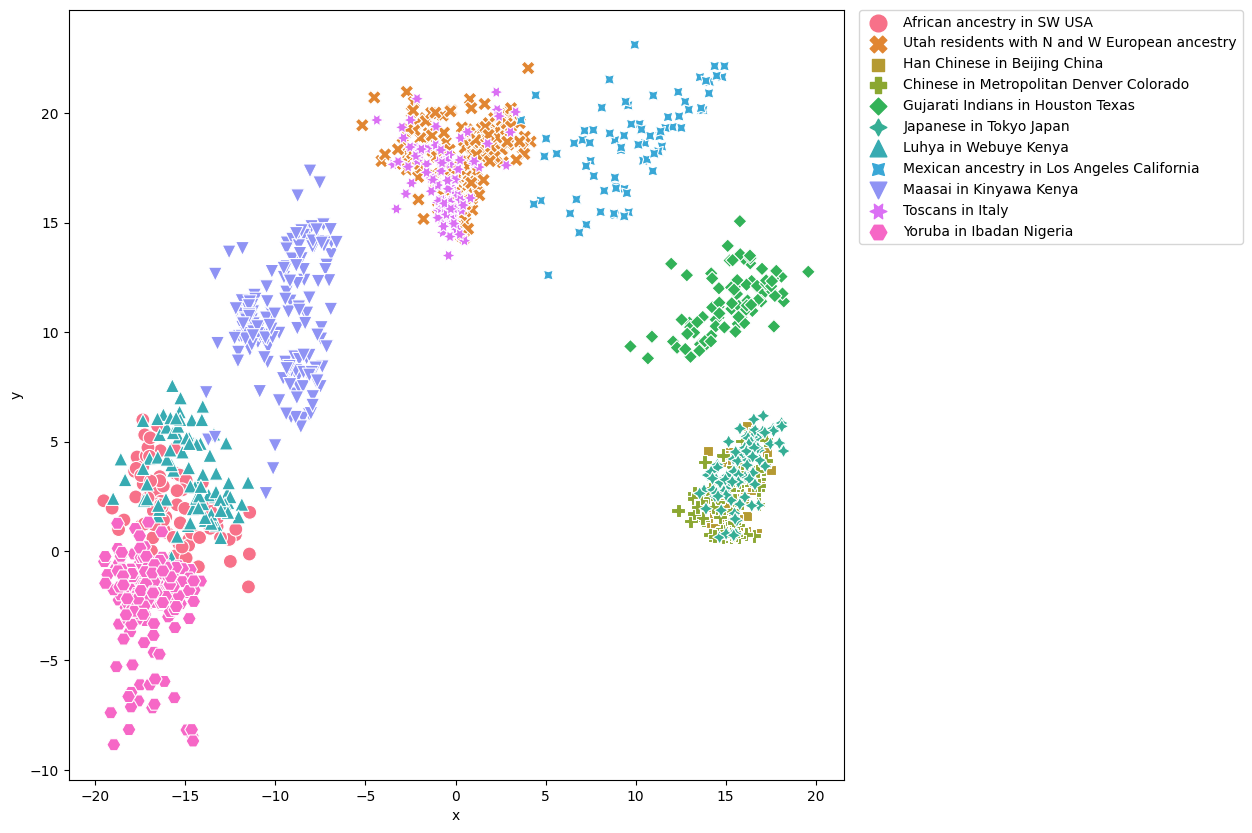

In [ ]:
embedded_points = trained_encoder.predict(geno_tensor)
print(embedded_points)

x = embedded_points[:,0]
y = embedded_points[:,1]
pop = pop
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

In [ ]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=1)
    return z_mean + K.exp(z_log_sigma) * epsilon

# Encoder
input = keras.Input(shape = (original_dim,))

h = layers.Dense(units = 1500, activation = 'relu')(input)
h = layers.BatchNormalization()(h)
h = layers.Dense(units = 250, activation = 'relu')(h)
h = layers.Dense(units = 25, activation = 'relu')(h)
# Bottleneck
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)
z = layers.Lambda(sampling, name='sampling_layer')([z_mean, z_log_sigma])
encoder = keras.Model(input, [z_mean, z_log_sigma, z], name='encoder')

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(units = 25, activation = 'relu')(latent_inputs)
x = layers.Dense(units = 250, activation = 'relu')(x)
x = layers.Dense(units = 1500, activation = 'relu')(x)
dec_output = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, dec_output, name='decoder')

# instantiate VAE model
output = decoder(encoder(input)[2])
vae_model = keras.Model(input, output, name='VAE')

In [ ]:
reconstruction_loss = original_dim * keras.losses.mse(input, output)  # use MSE
KL_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)
vae_loss = K.mean(reconstruction_loss + KL_loss)
vae_model.add_loss(vae_loss)
vae_model.compile(optimizer='adam')

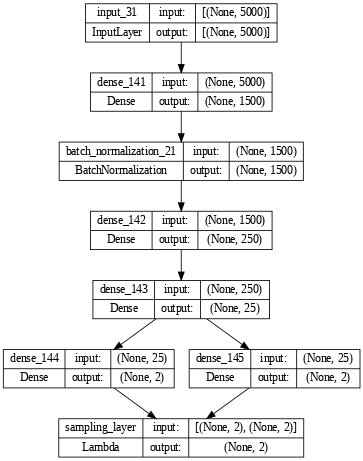

In [ ]:
plot_model(encoder, show_shapes=True, show_layer_names = True, dpi = 60)

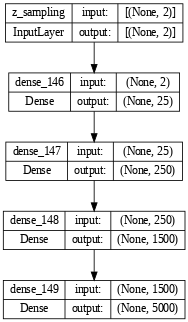

In [ ]:
plot_model(decoder, show_shapes=True, show_layer_names = True, dpi = 60)

In [ ]:
hp_epochs = 30
hp_batch_size = 32
hp_val_split = 0.2

vae_model.fit(train_tensor, train_tensor,
        epochs = hp_epochs,
        batch_size = hp_batch_size,
        shuffle = True,
        validation_split = hp_val_split)

Epoch 1/30
24/24 [==============================] - 8s 228ms/step - loss: 495.5819 - val_loss: 11541.3154
Epoch 2/30
24/24 [==============================] - 6s 266ms/step - loss: 369.0539 - val_loss: 355.4991
Epoch 3/30
24/24 [==============================] - 5s 221ms/step - loss: 344.8892 - val_loss: 339.4262
Epoch 4/30
24/24 [==============================] - 6s 263ms/step - loss: 333.8501 - val_loss: 332.0295
Epoch 5/30
24/24 [==============================] - 5s 216ms/step - loss: 327.2937 - val_loss: 328.1033
Epoch 6/30
24/24 [==============================] - 6s 251ms/step - loss: 324.9713 - val_loss: 326.3216
Epoch 7/30
24/24 [==============================] - 6s 231ms/step - loss: 324.0119 - val_loss: 325.7481
Epoch 8/30
24/24 [==============================] - 5s 217ms/step - loss: 324.0067 - val_loss: 325.4170
Epoch 9/30
24/24 [==============================] - 6s 262ms/step - loss: 323.4852 - val_loss: 325.6118
Epoch 10/30
24/24 [==============================] - 5s 218ms/

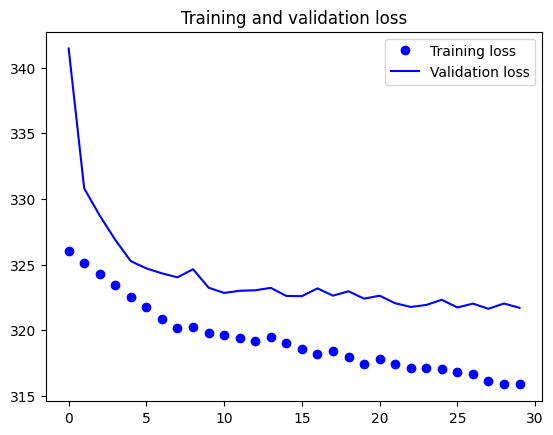

In [ ]:
loss = vae_model.history.history['loss']
val_loss = vae_model.history.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

37/37 [==============================] - 1s 21ms/step
[array([[ 0.10946293,  1.6379908 ],
       [-0.19524507,  0.84827495],
       [-0.35888317,  0.7927902 ],
       ...,
       [-0.02947776,  1.3002853 ],
       [ 0.13081308,  1.3805043 ],
       [-0.27376977,  1.3217776 ]], dtype=float32), array([[-2.3427675, -1.8056066],
       [-1.9156632, -1.4490807],
       [-1.8786201, -1.2377045],
       ...,
       [-1.8776844, -1.8033681],
       [-2.3057938, -1.8459293],
       [-1.9712316, -1.5221589]], dtype=float32), array([[ 0.0034585 ,  1.6979836 ],
       [-0.07620627,  0.72215927],
       [-0.5617876 ,  0.52854836],
       ...,
       [ 0.17412204,  1.5514481 ],
       [ 0.08474161,  1.3682321 ],
       [-0.09462763,  1.1295272 ]], dtype=float32)]


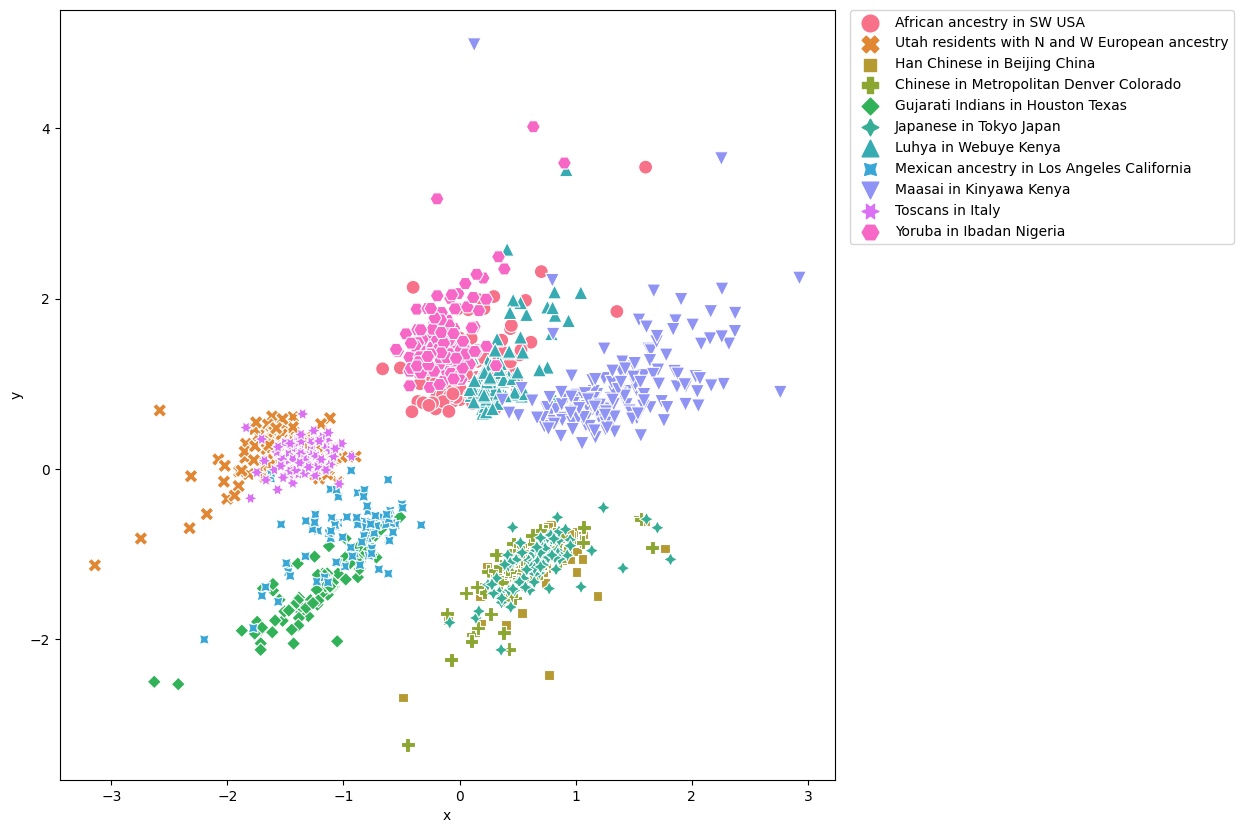

In [122]:
embedded_points = encoder.predict(geno_tensor)
print(embedded_points)

x = embedded_points[0][:,0]
y = embedded_points[0][:,1]
pop = pop
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

In [162]:
N_ind = 10
center = [-2, -0.5]
cx = K.random_normal(shape = [N_ind], mean = center[0], stddev = 0.1)
cy = K.random_normal(shape = [N_ind], mean = center[1], stddev = 0.1)
z_sample = np.column_stack((cx, cy))
z_sample

array([[-1.7144625 , -0.4996249 ],
       [-2.0686884 , -0.37838784],
       [-2.014274  , -0.5337421 ],
       [-2.0016365 , -0.56499684],
       [-1.9603547 , -0.5029502 ],
       [-1.9330964 , -0.41390002],
       [-1.8245691 , -0.5102214 ],
       [-2.1764903 , -0.66615444],
       [-1.9464548 , -0.53645134],
       [-1.9683152 , -0.6197554 ]], dtype=float32)

In [163]:
decoded = decoder.predict(z_sample,)
decoded

1/1 [==============================] - 0s 31ms/step


array([[0.31774452, 0.15078673, 0.06747469, ..., 0.53459066, 0.35686463,
        0.0154432 ],
       [0.3192935 , 0.15327679, 0.05871284, ..., 0.5438806 , 0.34862107,
        0.01239935],
       [0.32017818, 0.15243828, 0.06240514, ..., 0.5400669 , 0.3522282 ,
        0.01344395],
       ...,
       [0.32189786, 0.15108934, 0.06249202, ..., 0.53918433, 0.3529972 ,
        0.01294818],
       [0.3197197 , 0.15214634, 0.06379729, ..., 0.5388323 , 0.35328346,
        0.01394662],
       [0.3210742 , 0.1513171 , 0.06584131, ..., 0.53604543, 0.35610124,
        0.01427394]], dtype=float32)

In [164]:

new_geno = np.zeros(shape = decoded.shape)
new_geno[decoded <= 0.33] = 0
new_geno[np.logical_and(decoded > 0.33, decoded < 0.66)] = 1
new_geno[decoded > 0.66] = 2
print(new_geno)

[[0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]]


38/38 [==============================] - 1s 33ms/step


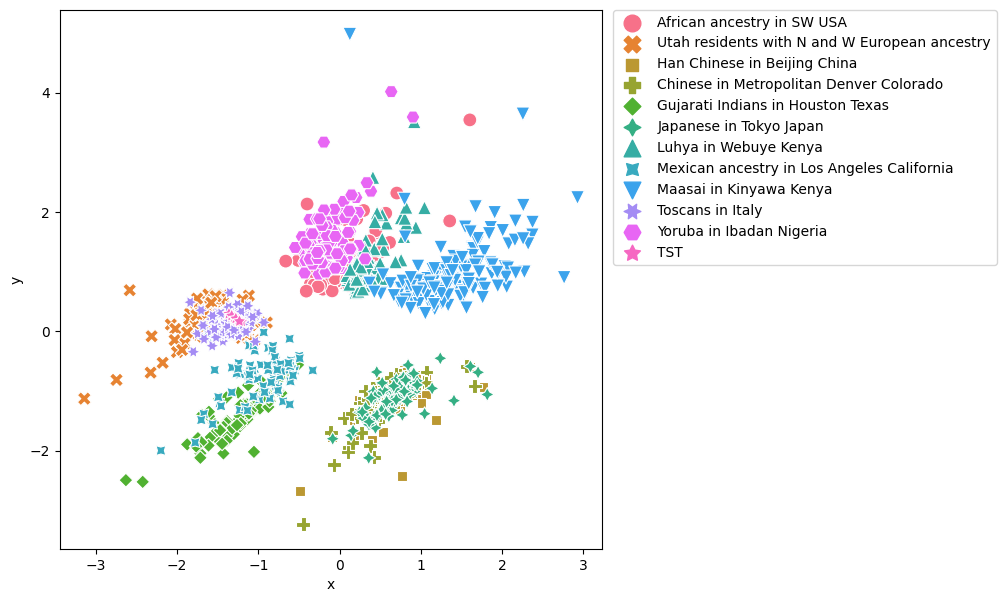

In [165]:
x_encoded = encoder.predict(np.row_stack((geno_tensor, decoded)), batch_size=32)
x = x_encoded[0][:, 0]
y = x_encoded[0][:, 1]
pop_list = [pheno['population'], pd.Series(np.repeat('TST', new_geno.shape[0]))]
pop = pd.concat(pop_list)
data_tmp = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (7, 7))
sns.scatterplot(x='x', y='y', data=data_tmp, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()